In [1]:
import igraph as ig
import numpy as np
from src import renormalizable_model, utils
from tqdm import tqdm
import scipy
from matplotlib import pyplot as plt

In [2]:
from IPython.display import clear_output

In [3]:
def create_degree_corrected_RM_graph(strengths, z, weighted=False, check_consistency=False):
    # if self_loops:
    #     new_strengths = strengths
    # else:
    #     new_strengths = renormalizable_model.convert_strengths_without_self_loops(strengths)
    new_strengths = strengths
    out_strengths = new_strengths[:,0]
    in_strengths = new_strengths[:,1]
    W = np.sum(out_strengths)
    num_nodes = len(out_strengths)
    prob_matrix = np.ones([num_nodes, num_nodes]) - np.exp(-z*out_strengths.reshape(num_nodes,1)@in_strengths.reshape(1,num_nodes))
    #random_numbers = np.random.random_sample([num_nodes,num_nodes])
    adjacency_matrix = np.zeros([num_nodes,num_nodes])
    for i in range(num_nodes):
        num_edges_i = 0
        while num_edges_i == 0:
            random_numbers = np.random.random_sample(num_nodes)
            edges_to_add = random_numbers < prob_matrix[i,:]
            num_edges_i = np.sum(edges_to_add)
        adjacency_matrix[i,:] = edges_to_add
    if weighted:
        weight_matrix = out_strengths.reshape(num_nodes,1)@in_strengths.reshape(1,num_nodes)/(W*prob_matrix)
        p_k_i_nonzero = 1-np.exp(-z*out_strengths*W)
        p_k_i_nonzero_matrix = np.diag(p_k_i_nonzero)
        weighted_adj_matrix = p_k_i_nonzero_matrix@(weight_matrix*adjacency_matrix)
        return utils.graph_from_adjacency(weighted_adj_matrix, weighted=True)
    return utils.graph_from_adjacency(adjacency_matrix, weighted=False)

In [4]:
def exp_num_of_links(strengths, z):
    new_strengths = strengths
    out_strengths = new_strengths[:,0]
    in_strengths = new_strengths[:,1]
    W = np.sum(out_strengths)
    num_nodes = len(out_strengths)
    prob_matrix = np.ones([num_nodes, num_nodes]) - np.exp(-z*out_strengths.reshape(num_nodes,1)@in_strengths.reshape(1,num_nodes))
    p_k_i_nonzero = 1/(1-np.exp(-z*out_strengths*W))
    p_k_i_nonzero_matrix = np.diag(p_k_i_nonzero)
    prob_matrix_k_nonzero = p_k_i_nonzero_matrix@prob_matrix
    return np.sum(prob_matrix_k_nonzero)

In [5]:
weighted_adj_matrix = np.loadtxt(open("data/fg_empiricalNTW(node_num=1000).csv", "rb"), delimiter=",").reshape((1000,1000))

In [6]:
out_strengths = np.sum(weighted_adj_matrix, axis=1)
in_strengths = np.sum(weighted_adj_matrix, axis=0)
strengths = np.stack([out_strengths, in_strengths], axis=1)

num_of_links = np.sum(weighted_adj_matrix > 0)

In [7]:
print("Number of links in synthetic graph: ", num_of_links)

Number of links in synthetic graph:  7076


In [8]:
exp_z_details = scipy.optimize.root_scalar(lambda z: exp_num_of_links(strengths, z) - num_of_links, method="bisect", bracket=[0.001,1])
print(exp_z_details)

      converged: True
           flag: converged
 function_calls: 41
     iterations: 39
           root: 0.017420408911440973


In [9]:
exp_z = exp_z_details.root

In [10]:
ensemble_degree_corrected = [create_degree_corrected_RM_graph(np.array([out_strengths, in_strengths]).T, exp_z, weighted=True) for _ in tqdm(range(1000))]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [08:41<00:00,  1.92it/s] 


In [11]:
avg_edges = np.mean([g.ecount() for g in ensemble_degree_corrected])
print("Average number of edges: ", avg_edges)

Average number of edges:  7073.677


In [12]:
avg_degree_out = np.mean([g.degree(mode="out").count(0) for g in ensemble_degree_corrected])
print("Average out-degree: ", avg_degree_out)

Average out-degree:  0.0


In [13]:
avg_degree_out = np.mean([g.degree(mode="in").count(0) for g in ensemble_degree_corrected])
print("Average in-degree: ", avg_degree_out)

Average in-degree:  394.567


### Strengths correspondence

In [14]:
def compute_strengths(graph, mode):
    weighted_adj_matrix = utils.weighted_adj_matrix(graph)
    if mode == "out":
        return np.sum(weighted_adj_matrix, axis=1)
    elif mode == "in":
        return np.sum(weighted_adj_matrix, axis=0)

In [15]:
exp_strengths_out = np.mean([compute_strengths(graph, mode="out") for graph in tqdm(ensemble_degree_corrected)], axis=0)

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


Text(0, 0.5, '$\\log(s_{out})$')

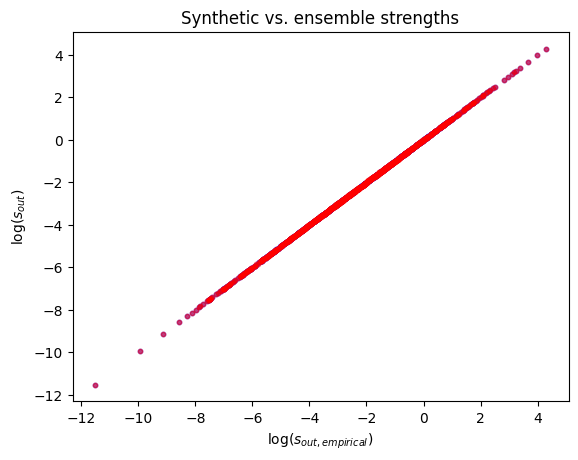

In [16]:
plt.title("Synthetic vs. ensemble strengths")
plt.scatter(np.log(out_strengths), np.log(out_strengths), s=10, c="blue", alpha=.5)
plt.scatter(np.log(out_strengths), np.log(exp_strengths_out), s=10, c="red", alpha=.5)
plt.xlabel(r"$\log(s_{out,empirical})$")
plt.ylabel(r"$\log(s_{out})$")

Strengths are in a great correspondence

### Comparison with original model

In [17]:
def exp_num_of_links(z):
    return np.sum([1 - np.exp(-z*x_i*y_j) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [18]:
exp_z_details = scipy.optimize.root_scalar(exp_num_of_links, method="bisect", bracket=[0.001,1])
print(exp_z_details)

      converged: True
           flag: converged
 function_calls: 41
     iterations: 39
           root: 0.019080723824868986


In [19]:
exp_z = exp_z_details.root

In [20]:
ensemble_vanilla = [renormalizable_model.create_RM_graph(strengths, exp_z) for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]


In [21]:
avg_edges = np.mean([g.ecount() for g in ensemble_vanilla])
print("Average number of edges, original model: ", avg_edges)

Average number of edges, original model:  7073.07


In [22]:
avg_degree_out = np.mean([g.degree(mode="out").count(0) for g in ensemble_vanilla])
print("Average out-degree, original model: ", avg_degree_out)

Average out-degree, original model:  387.265


In [23]:
avg_degree_out = np.mean([g.degree(mode="in").count(0) for g in ensemble_vanilla])
print("Average in-degree, original model: ", avg_degree_out)

Average in-degree, original model:  387.48
